In [365]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

sns.set(style="darkgrid")

In [366]:
dataset = "iris_data.txt"

df = pd.read_csv(dataset,delimiter=',',header=None,names=['sepal_length','sepal_width','petal_length','petal_width','specie'])

df.head()

,sepal_length,sepal_width,petal_length,petal_width,specie
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [369]:
df = df.drop(df[df.specie == 'Iris-setosa'].index)
X = df[['sepal_width','petal_width']].values # Feature set
Y = df['sepal_length'].values # Class labels

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.4,random_state=89)

scaler = preprocessing.StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

y_train = y_train
y_test = y_test


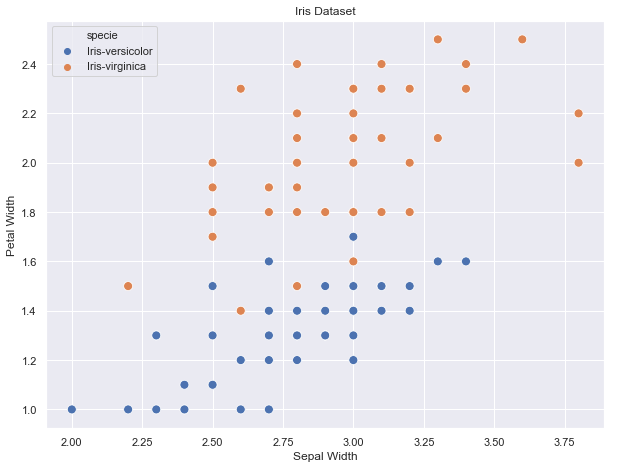

In [371]:
fig,ax = plt.subplots(figsize=(10,7.5))
ax = sns.scatterplot(x="sepal_width", y="petal_width",hue="specie", data=df,s=80)
plt.title("Iris Dataset")
plt.xlabel("Sepal Width")
plt.ylabel("Petal Width")
plt.show()

In [372]:
class Perceptron():
    def __init__(self,input_dim):
        self.weights = np.random.rand(input_dim) / 10 # Initialize weights to random numbers
        self.bias = np.random.random() / 10
    def activate(self,x,activation='relu'):
        output = np.dot(x,self.weights) + self.bias # w*x + b * 1
        if(activation == 'relu'):
            return self.relu(output)
        elif(activation == 'sigmoid'):
            return self.sigmoid(output)
        elif(activation == 'lu'):
            return self.lu(output)
        
    def sigmoid(self,x):
        return 1.0 / (1.0 + np.exp(-x))
    def relu(self,x):
        return np.maximum(0,x)
    def lu(self,x):
        return x

In [373]:
class Layer(object):
    def __init__(self):
        pass
    
    def compile(self):
        pass
    
    def activate(self,x):
        pass

class InputLayer(Layer):
    def __init__(self,input_dim):
        self.input_dim = input_dim
        self.units = input_dim
    
    def activate(self,x):
        return x
    
class DenseLayer(Layer):
    def __init__(self,units,activation='relu'):
        self.perceptrons = []
        self.units = units
        self.input_dim = 0
        self.activation = activation
        self.lastActivation = []
            
    def compile(self):
        # Create perceptrons
        for i in range(0,self.units):
            self.perceptrons.append(Perceptron(self.input_dim))
            
    def activate(self,x):
        outputs = []
        for unit in self.perceptrons:
            outputs.append(unit.activate(x,self.activation))
        self.lastActivation = outputs
        return outputs
    
    def get_weights(self):
        weights = []
        for unit in self.perceptrons:
            weights.append(unit.weights)
        return np.array(weights)
    
    def update_weights(self,new_weights):
        for i in range(0,self.units):
            self.perceptrons[i].weights = new_weights[i] 

    def get_gradients(self):
        gradients = []
        for i in self.lastActivation:
            grad = self.get_gradient(i)
            gradients.append(grad)
        return np.array(gradients)
    
    def get_gradient(self,output):
        if(self.activation == 'relu'):
            return self.relu_grad(output)
        elif(self.activation == 'sigmoid'):
            return self.sigmoid_grad(output)
        elif(self.activation == 'lu'):
            return self.relu_grad(output)
        
    def sigmoid_grad(self,output):
        return output * (1.0 - output)

    def relu_grad(self,output):
        if(output < 0):
            return 0.0
        else:
            return 1.0
    

In [387]:
class Model():
    def __init__(self,lr = 0.3,loss_function='mse'):
        self.layers = []
        self.layerCount = 0
        self.lr = lr
        self.loss_function = loss_function
        
    def Add(self,layer):
        if(not isinstance(layer,Layer)):
            raise Exception("Parameter should be type of Layer.")
        
        if(self.layerCount == 0 and not isinstance(layer,InputLayer)):
            raise Exception("First Layer should be type of Input Layer.")
        
        self.layers.append(layer)
        self.layerCount += 1
        
    def compile(self):
        # Infer layer input dimensions
        for i in range(1,self.layerCount):
            dim = self.layers[i - 1].units
            self.layers[i].input_dim = dim
            self.layers[i].compile()
    
    def train(self,X,y,epoch = 10):
        
        history = pd.DataFrame({'epoch':[None],'loss':[None]})

        for e in range(0,epoch):
            error = 0
            for row,target in zip(X,y):
                error += self.backPropagate(row,target)
            loss = np.mean(error)
            history.loc[history.shape[0]] = [e,loss]
            print(f'Epoch: {e}, {self.loss_function}: {loss}')
        
        return history
        
    def loss(self,error):
        if(self.loss_function == 'mse'):
            return np.mean(np.square(error))
    
    def predict(self,x):
        return self.feedForward(x)
        
    def feedForward(self,x):
        for layer in self.layers:
            x = layer.activate(x)
        return np.array(x)
    
    def backPropagate(self,x,y):
                
        output_layer = self.layers[-1]
        
        output = self.feedForward(x)
        output_error = y - output # compute error
        output_delta = output_error * output_layer.relu_grad(output)
        
        output_layer.delta = np.array(output_delta)
                
        for i in range(self.layerCount - 2,0,-1):
            
            nextLayer = self.layers[i +  1]
            currentLayer = self.layers[i]                
            
            w2 = nextLayer.get_weights()
            d2 = nextLayer.delta
            
            #print(d.shape)
            #print(w.shape)

            error = np.dot(d2,w2)
            
            g = currentLayer.get_gradients()

            delta = error * g
            currentLayer.delta = delta          
        
        for i in range(self.layerCount - 2,0,-1):
            nextLayer = self.layers[i +  1]
            currentLayer = self.layers[i]                
            
            for k in range(0,nextLayer.units):
                w = nextLayer.get_weights()
                w += self.lr * np.dot(nextLayer.delta[k],currentLayer.lastActivation)
                nextLayer.update_weights(w)
                nextLayer.perceptrons[k].bias += self.lr * nextLayer.delta[k]
        return np.sum(output_error**2)


Epoch: 0, mse: 402.17478910854516
Epoch: 1, mse: 19.573728642433135
Epoch: 2, mse: 18.045786443920573
Epoch: 3, mse: 17.715053609650013
Epoch: 4, mse: 17.431422954336647
Epoch: 5, mse: 17.172438944373624
Epoch: 6, mse: 16.935308769941123
Epoch: 7, mse: 16.718160284100037
Epoch: 8, mse: 16.519306480991162
Epoch: 9, mse: 16.337202977731053
Epoch: 10, mse: 16.17043498052372
Epoch: 11, mse: 16.01770640644676
Epoch: 12, mse: 15.877829956933374
Epoch: 13, mse: 15.74971802142898
Epoch: 14, mse: 15.632374340273094
Epoch: 15, mse: 15.524886363434549
Epoch: 16, mse: 15.426418247078352
Epoch: 17, mse: 15.336204434779395
Epoch: 18, mse: 15.25354377463152
Epoch: 19, mse: 15.177794127563304
Epoch: 20, mse: 15.108367425895624
Epoch: 21, mse: 15.044725144590954
Epoch: 22, mse: 14.986374150773758
Epoch: 23, mse: 14.93286289997013
Epoch: 24, mse: 14.883777950144768
Epoch: 25, mse: 14.83874076702434
Epoch: 26, mse: 14.797404796405809
Epoch: 27, mse: 14.759452781174396
Epoch: 28, mse: 14.724594302612381
E

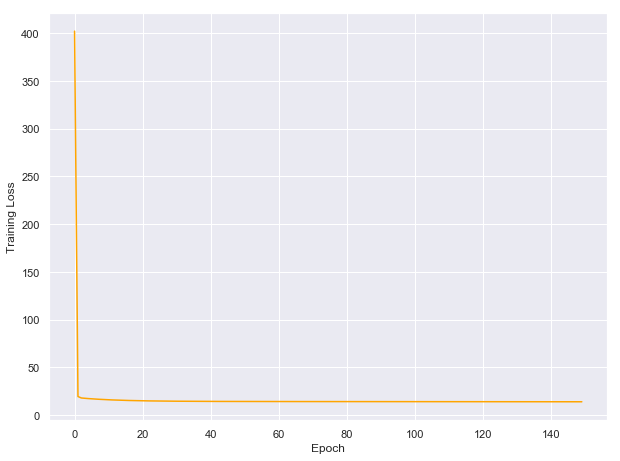

In [388]:
m = Model(lr=0.05)

m.Add(InputLayer(input_dim=2))
m.Add(DenseLayer(3,activation='relu'))
m.Add(DenseLayer(1,activation='lu'))

m.compile()

history = m.train(x_train,y_train,150)

fig = plt.figure(figsize=(10,7.5))
ax = sns.lineplot(x='epoch',y='loss',color='orange',data=history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [389]:
for _x,_y in zip(x_train[0:50],y_train[0:50]):
    pred = m.predict(_x)
    acc = pred * 100 / _y
    print("Pred: ",pred)
    print("Target: ",_y)
    print()

Pred:  [6.24719771]
Target:  5.4

Pred:  [6.34134719]
Target:  6.7

Pred:  [6.57218411]
Target:  6.5

Pred:  [6.15045579]
Target:  5.8

Pred:  [6.43549667]
Target:  6.4

Pred:  [6.67022225]
Target:  6.0

Pred:  [6.57477655]
Target:  7.2

Pred:  [7.32537993]
Target:  7.7

Pred:  [6.34134719]
Target:  6.9

Pred:  [6.38907004]
Target:  7.0

Pred:  [5.69574646]
Target:  5.0

Pred:  [6.52575748]
Target:  6.8

Pred:  [6.06405367]
Target:  6.3

Pred:  [5.7309534]
Target:  5.5

Pred:  [6.29492056]
Target:  6.7

Pred:  [6.29232812]
Target:  7.3

Pred:  [5.75865104]
Target:  5.8

Pred:  [7.04163528]
Target:  6.3

Pred:  [5.97966497]
Target:  5.7

Pred:  [6.29232812]
Target:  6.3

Pred:  [6.06907476]
Target:  6.4

Pred:  [5.76480469]
Target:  6.2

Pred:  [5.93244953]
Target:  5.2

Pred:  [5.84303974]
Target:  6.1

Pred:  [5.69574646]
Target:  6.0

Pred:  [6.99391243]
Target:  6.3

Pred:  [6.71276022]
Target:  6.9

Pred:  [5.93747062]
Target:  6.1

Pred:  [6.99391243]
Target:  6.7

Pred:  [6.11126

In [449]:
dataset = "data_regression1.txt"
df2 = pd.read_csv(dataset,delimiter=',',header=None,names=['feature','output'])

xshape = X.shape
yshape = Y.shape
X = df2['feature'].values.reshape(-1,1)
Y = df2['output'].values.reshape(-1,1)

scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(X)
mx = np.max(Y)
Y = Y / mx

X = X.reshape(xshape)
Y = Y.reshape(yshape)

Epoch: 0, mse: 1.5530573580739166
Epoch: 1, mse: 0.1306433827987173
Epoch: 2, mse: 0.11977121954650446
Epoch: 3, mse: 0.11913964850036622
Epoch: 4, mse: 0.11853099561579528
Epoch: 5, mse: 0.11794184488188586
Epoch: 6, mse: 0.11737025671946749
Epoch: 7, mse: 0.11681452713263962
Epoch: 8, mse: 0.11627315146044617
Epoch: 9, mse: 0.11574479608995793
Epoch: 10, mse: 0.115228275394107
Epoch: 11, mse: 0.11472253286634368
Epoch: 12, mse: 0.11422662566149763
Epoch: 13, mse: 0.11373971192916037
Epoch: 14, mse: 0.11326104045985048
Epoch: 15, mse: 0.11278994226633637
Epoch: 16, mse: 0.11232582380069915
Epoch: 17, mse: 0.11186816156770144
Epoch: 18, mse: 0.11141649794084428
Epoch: 19, mse: 0.1109704380221058
Epoch: 20, mse: 0.1105296474117749
Epoch: 21, mse: 0.11009385077251317
Epoch: 22, mse: 0.10966283108274685
Epoch: 23, mse: 0.10923642947937041
Epoch: 24, mse: 0.10881454558893154
Epoch: 25, mse: 0.10839713824022612
Epoch: 26, mse: 0.10798422643982847
Epoch: 27, mse: 0.10757589047576253
Epoch: 2

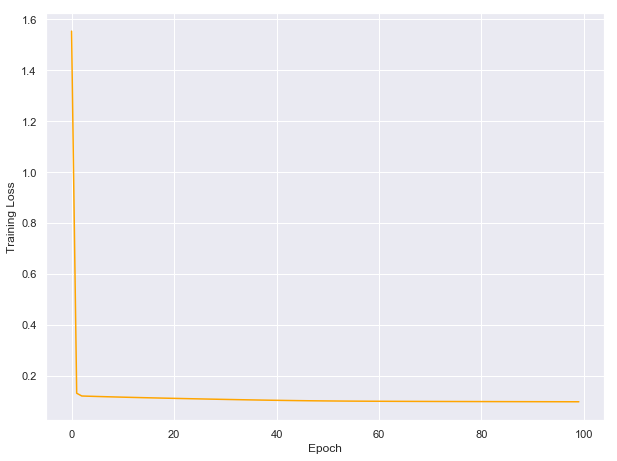

In [471]:
m = Model(lr=0.4)

m.Add(InputLayer(input_dim=1))
m.Add(DenseLayer(16,activation='relu'))
m.Add(DenseLayer(12,activation='relu'))
m.Add(DenseLayer(4,activation='relu'))
m.Add(DenseLayer(2,activation='relu'))
m.Add(DenseLayer(1,activation='lu'))

m.compile()

history2 = m.train(X,Y,100)

fig = plt.figure(figsize=(10,7.5))
ax = sns.lineplot(x='epoch',y='loss',color='orange',data=history2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

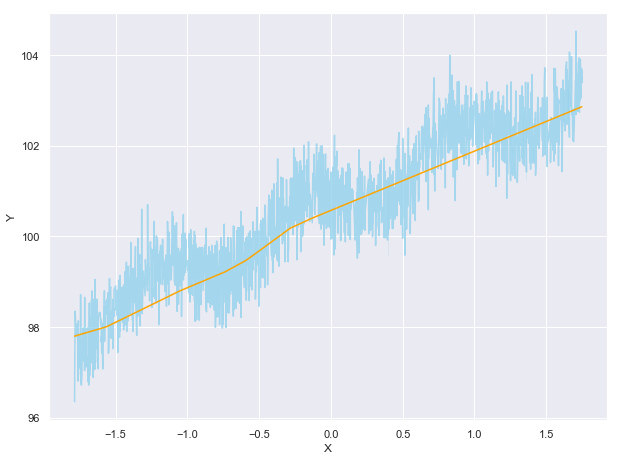

In [470]:
fit = pd.DataFrame({'x':[None],'pred':[None],'y':[None]})

for _x,_y in zip(X,Y):
    pred = m.predict(_x)
    fit.loc[fit.shape[0]] = [_x[0],pred[0] * mx,_y[0] * mx]
    
fig = plt.figure(figsize=(10,7.5))
ax = sns.lineplot(x='x',y='y',color='skyblue',alpha=0.7,data=fit)
ax = sns.lineplot(x='x',y='pred',color='orange',data=fit)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()